 Data loaded: (328890, 27)
Columns: ['fips', 'year', 'tot_clms', 'tot_opioid_clms', 'tot_prscrbrs', 'tot_opioid_prscrbrs', 'opioid_prscrbng_rate', 'state', 'county', 'pct_uninsured', 'pct_unemployed', 'pct_children_in_poverty', 'income_ratio', 'mental_health_provider_rate', 'primary_care_physicians_rate', 'pct_adults_reporting_currently_smoking', 'pct_adults_with_obesity', 'pct_excessive_drinking', 'pct_severe_housing_problems', 'injury_death_rate', 'opioid_claims_share', 'cost_per_claim', 'claims_per_1k', 'log1p_claims_per_1k', 'population', 'opioid_cost', 'opioid_cost_per_capita']
✅ NaN count after cleaning: 0
count    328890.000000
mean         11.285037
std          65.017415
min           0.000000
25%           0.000000
50%           0.000000
75%           0.020356
max        6490.470000
Name: opioid_cost_per_capita, dtype: float64
Training data: (230223, 15) Testing data: (98667, 15)
NaN in target: 0
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best Model Parame

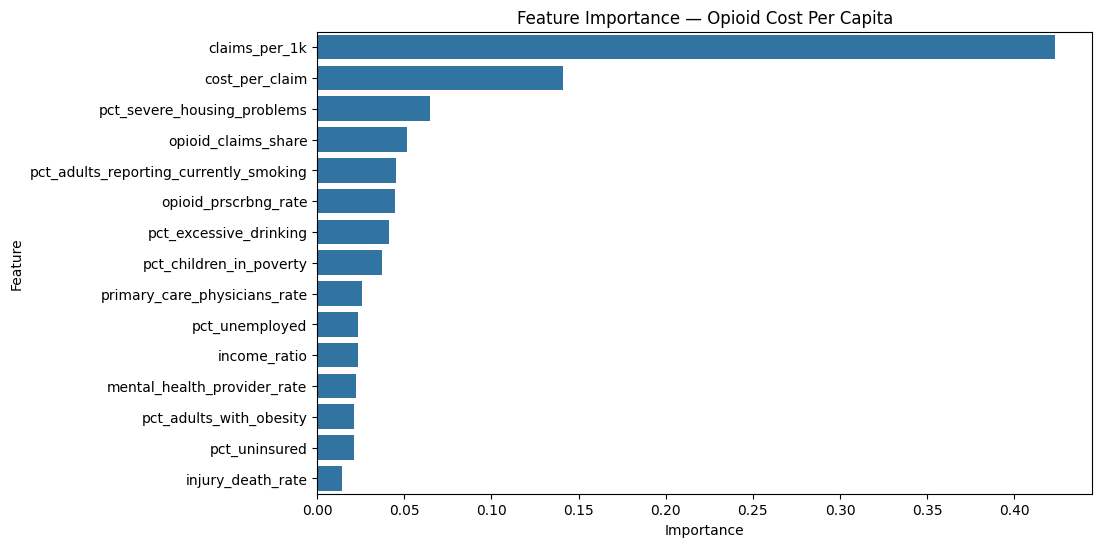

💡 Scenario: pct_uninsured changes by -10.0% → Average Δ Cost per Capita: $-0.02
💡 Scenario: pct_unemployed changes by -10.0% → Average Δ Cost per Capita: $0.10
💡 Scenario: pct_children_in_poverty changes by -5.0% → Average Δ Cost per Capita: $-0.09
💡 Scenario: opioid_prscrbng_rate changes by -10.0% → Average Δ Cost per Capita: $-0.04
💡 Scenario: cost_per_claim changes by -5.0% → Average Δ Cost per Capita: $-0.36
💡 Scenario: opioid_claims_share changes by -10.0% → Average Δ Cost per Capita: $-0.23
Scenario simulation complete.


In [14]:
# ==========================================
# 07B_Opioid_Cost_Simulation.ipynb
# ==========================================

# --- STEP 1: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# --- STEP 2: Load Final Cleaned Dataset
panel_path = "../data/cleaned/feature_engineered_panel.csv"
panel = pd.read_csv(panel_path)
print(" Data loaded:", panel.shape)
print("Columns:", panel.columns.tolist())

# --- STEP 3: Handle or Recalculate opioid_cost_per_capita
eps = 1e-9

# Recalculate cost per capita safely (if missing or invalid)
if "opioid_cost_per_capita" not in panel.columns:
    print("⚠️ Recomputing opioid_cost_per_capita ...")
    if {"cost_per_claim", "tot_opioid_clms", "population"} <= set(panel.columns):
        panel["opioid_cost_per_capita"] = (
            panel["cost_per_claim"].fillna(0) * panel["tot_opioid_clms"].fillna(0)
        ) / (panel["population"].replace(0, np.nan) + eps)
    else:
        raise ValueError("Missing required columns to compute opioid_cost_per_capita.")

# Replace inf/nan
panel["opioid_cost_per_capita"].replace([np.inf, -np.inf], np.nan, inplace=True)
panel["opioid_cost_per_capita"].fillna(0, inplace=True)
print("✅ NaN count after cleaning:", panel["opioid_cost_per_capita"].isna().sum())
print(panel["opioid_cost_per_capita"].describe())

# --- STEP 4: Define features and target
feature_cols = [
    "pct_uninsured", "pct_unemployed", "pct_children_in_poverty", "income_ratio",
    "mental_health_provider_rate", "primary_care_physicians_rate",
    "pct_adults_reporting_currently_smoking", "pct_adults_with_obesity",
    "pct_excessive_drinking", "pct_severe_housing_problems", "injury_death_rate",
    "opioid_prscrbng_rate", "opioid_claims_share", "cost_per_claim", "claims_per_1k"
]

target_col = "opioid_cost_per_capita"

X = panel[feature_cols].copy()
y = panel[target_col].copy()

# --- STEP 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Training data:", X_train.shape, "Testing data:", X_test.shape)
print("NaN in target:", y_train.isna().sum())

# --- STEP 6: Modeling Pipeline
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(random_state=42))
])

# --- STEP 7: Hyperparameter Tuning
param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [10, 15, 20, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2"]
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=10,
    scoring="r2",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
print("✅ Best Model Parameters:", random_search.best_params_)

# --- STEP 8: Evaluate Model
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

# --- STEP 9: Save Model
joblib.dump(best_model, "../models/final_random_forest.pkl")
print("✅ Model saved to ../models/final_random_forest.pkl")

# --- STEP 10: Feature Importance
model = best_model.named_steps["model"]
feat_imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance — Opioid Cost Per Capita")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# --- STEP 11: Simulation Scenarios

def simulate_scenario(panel, feature, change_pct):
    """Simulate cost impact when a feature improves by change_pct."""
    panel_copy = panel.copy()
    if feature in panel_copy.columns:
        base_cost = best_model.predict(panel_copy[feature_cols])
        panel_copy[feature] = panel_copy[feature] * (1 + change_pct/100)
        new_cost = best_model.predict(panel_copy[feature_cols])
        delta = (new_cost - base_cost).mean()
        print(f"💡 Scenario: {feature} changes by {change_pct:+.1f}% → Average Δ Cost per Capita: ${delta:.2f}")

# Example SDOH scenarios
simulate_scenario(panel, "pct_uninsured", -10)
simulate_scenario(panel, "pct_unemployed", -10)
simulate_scenario(panel, "pct_children_in_poverty", -5)

# Example PBM program levers (simulate as proxy effects)
simulate_scenario(panel, "opioid_prscrbng_rate", -10)  # stricter formulary management
simulate_scenario(panel, "cost_per_claim", -5)          # better negotiated prices
simulate_scenario(panel, "opioid_claims_share", -10)    # utilization management impact

print("Scenario simulation complete.")